# BiasAwareGridSearchCV (BAGS) on Recidivism
By Jayson Leach

In [1]:
# data processing
import pandas as pd
import numpy as np
from datetime import datetime

# data visualization
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import seaborn as sns

# model
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# fairness metrics
import sys
sys.path.insert(0, '../')

# fairness and gridsearch
import joblib
import yaml
import os
from util import *
from bias_aware_gridsearch import *

# for looks
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style='darkgrid')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Importing & Filtering Data
For ease of use, I used Propublica's combined and filtered dataset they created from compas.db. The dataset cotains one row for every person and only contains people who recieved COMPAS scores.

In [2]:
compas = pd.read_csv('compas-scores.csv')
# copy filtration methods from ProPublica analysis
compas = compas[(compas['is_recid'] != -1) & (compas['c_charge_degree'] != 'O') & 
                (compas['score_text'] != 'N/A')].drop(columns='decile_score.1')
compas = compas.replace('NaN', np.nan)
compas.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,vr_charge_degree,vr_offense_date,vr_charge_desc,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,type_of_assessment,score_text,screening_date
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,NaN,NaN,NaN,Risk of Violence,1,Low,2013-08-14,Risk of Recidivism,Low,2013-08-14
2,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Violence,1,Low,2013-01-27,Risk of Recidivism,Low,2013-01-27
3,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,NaN,NaN,NaN,Risk of Violence,3,Low,2013-04-14,Risk of Recidivism,Low,2013-04-14
4,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,NaN,NaN,NaN,Risk of Violence,6,Medium,2013-01-13,Risk of Recidivism,High,2013-01-13
5,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,NaN,NaN,NaN,Risk of Violence,1,Low,2013-03-26,Risk of Recidivism,Low,2013-03-26


The dataset has 46 columns all having to do with either the person's demographics, their criminal history, or information regarding their COMPAS scoring. It will later be reduced to 16 after dropping columns with NaN values, those involving specifically violent recidivism, and personal information.

In [3]:
compas.shape

(11002, 46)

The analysis done by ProPublica advises to remove datapoitns with differences between COMPAS screening date and arrest date greater than 30 days, because of potential unreliability. I concur that too large of a difference could be a sign of unreliable data, but I also think it is important to maintain 10,000 data points. In addition, there could be other reasons for large differences in dates, like legal issues or processing times depending on the severity of the crime. I chose to compromise and remove entries with arrest and COMPAS screening difference larger than 90 days in order to  maintaining 10,000 data points.


In [4]:
days = 90
data = compas[compas['days_b_screening_arrest'].apply(np.abs) <= days]

In [5]:
data = data[data.decile_score > 0]
data = data.dropna(axis=1)

In [6]:
# create variable for length of stay
data['c_jail_in'] = data['c_jail_in'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
data['c_jail_out'] = data['c_jail_out'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
data['stay_length'] = data['c_jail_out'] - data['c_jail_in']
data['stay_length'] = data['stay_length'].apply(lambda x: x.total_seconds())

In [7]:
# drop misc columns (most revolving violent recidivism)
data = data[['id', 'sex', 'age', 'age_cat', 'race', 'days_b_screening_arrest', 'c_days_from_compas',
             'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count',
            'c_charge_degree', 'stay_length', 'decile_score', 'score_text', 'is_recid']]

In [8]:
data.columns

Index(['id', 'sex', 'age', 'age_cat', 'race', 'days_b_screening_arrest',
       'c_days_from_compas', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'c_charge_degree', 'stay_length',
       'decile_score', 'score_text', 'is_recid'],
      dtype='object')

In [9]:
print('Number of data points after filtering:', data.shape[0])

Number of data points after filtering: 10010


## Looking at the Data: *Trends and Plots*

I already know that the goal of a model trained on this data will be to predict decile_score or score_text risk (Low, Medium, High). Thus, I will look at how different groupings are distributed with respect for those two variables.

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,10010.0,5.887682e+03,3.398811e+03,1.0,2937.25,5884.0,8831.75,11757.0
age,10010.0,3.483596e+01,1.187217e+01,18.0,25.00,32.0,42.00,96.0
days_b_screening_arrest,10010.0,-3.685814e+00,1.447769e+01,-90.0,-1.00,-1.0,-1.00,90.0
c_days_from_compas,10010.0,2.792977e+01,2.478921e+02,0.0,1.00,1.0,1.00,9485.0
juv_fel_count,10010.0,6.313686e-02,4.634829e-01,0.0,0.00,0.0,0.00,20.0
juv_misd_count,10010.0,7.912088e-02,4.614564e-01,0.0,0.00,0.0,0.00,13.0
juv_other_count,10010.0,9.850150e-02,4.635670e-01,0.0,0.00,0.0,0.00,11.0
priors_count,10010.0,3.160340e+00,4.690391e+00,0.0,0.00,1.0,4.00,38.0
stay_length,10010.0,1.970038e+06,6.141014e+06,-42137.0,77687.00,108440.5,852726.25,186015169.0
decile_score,10010.0,4.340460e+00,2.853497e+00,1.0,2.00,4.0,7.00,10.0


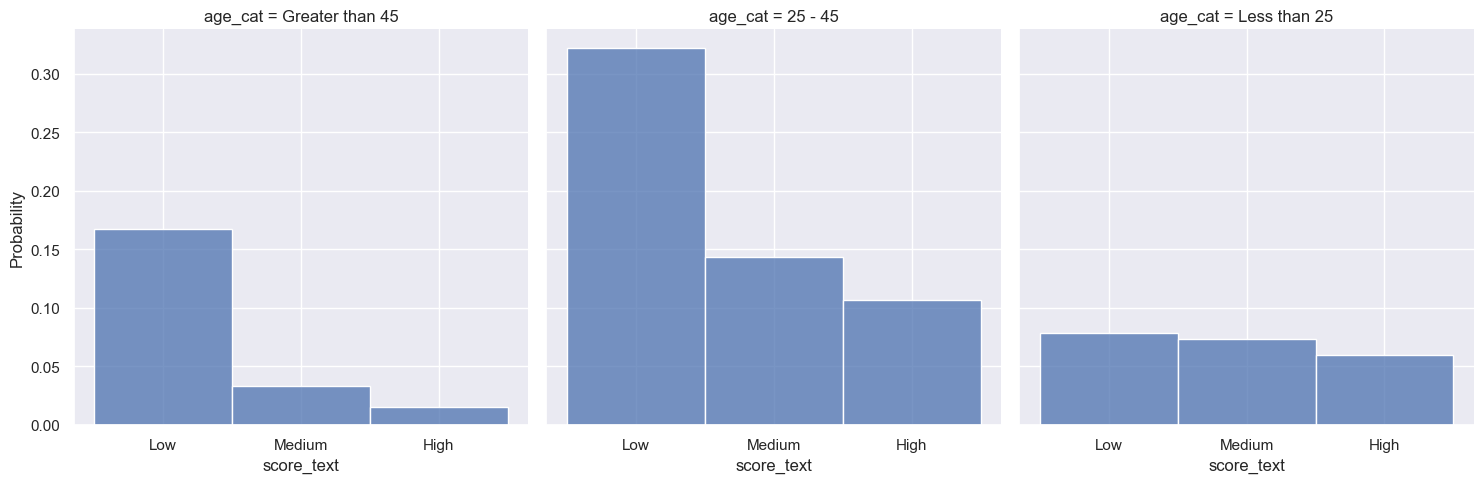

In [11]:
sns.displot(data, x='score_text', col='age_cat', stat='probability')
plt.show()

Above are three plots. The left-most plot is showing the distribution of risk catgegories with individuals between 45 and 96. Here, we can see low risk of recidivism makes up the majority of this group. The middle plot is showing the distribution of risk categories with individuals between the ages of 25 and 45. Similarly, low recidivism makes up the majority of this age group. The right-most plot is showing the distribution of risk catgegories with individuals between 18 and 25. Here, the difference in recidivism risk is much lower, with all three categories of risk being near even.

We can also look at the areas of the bars in each age categories to see that the majority of the people in the data are between 25 and 45, accounting for around 57% of the data. Both other categories account for around 21% each, with the group 45 and older being slightly larger by 37 entries.

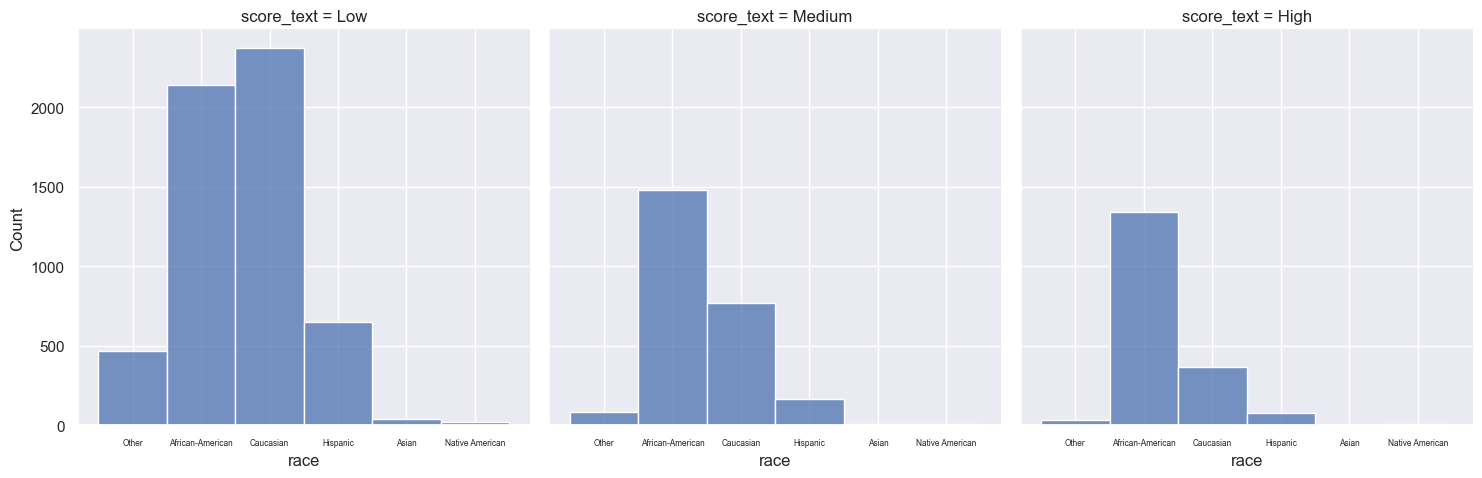

In [12]:
plot = sns.displot(data, x='race', col='score_text')
plot.tick_params(axis='x', which='major', labelsize=6)
plt.show()

Above are another three plots. This time we are looking at the distribution of race within each risk category. The left-most plot is showing the distribution of race within the 'Low' risk category. Here, we can see 'Caucasian' and 'African-American' are the 1 and 2 respectively. The middle plot is showing the distribution of race within the 'Medium' risk category. This one is much different from the low; 'African-American' hurdles 'White' to be the most in this risk category. The right-most plot is showing the distribution of race within the 'High' risk category. This is similar to the medium group with all racial groups except 'African-Anerican' dropping even more.

Based on the previous graphs, it is clear that racial groups of black and white are the most present in the data. It can also be suspected that white is not distributed similarly to the other racial groups with regards to risk. Instead of looking at score_text, I want to view the raw decile_scores. Below, the data is filtered with the goal of finding the difference in distributions between the two largest groups (white and black) with respect to decile scores.

In [13]:
bw_data = data[(data['race'] == 'Caucasian')| (data['race'] == 'African-American')]
bw_data = bw_data.groupby(['race', 'decile_score']).count()['id'].reset_index().rename(columns={'id':'count'})
bw_data['proportion'] = bw_data.groupby('race')['count'].transform(lambda x: x / x.sum())

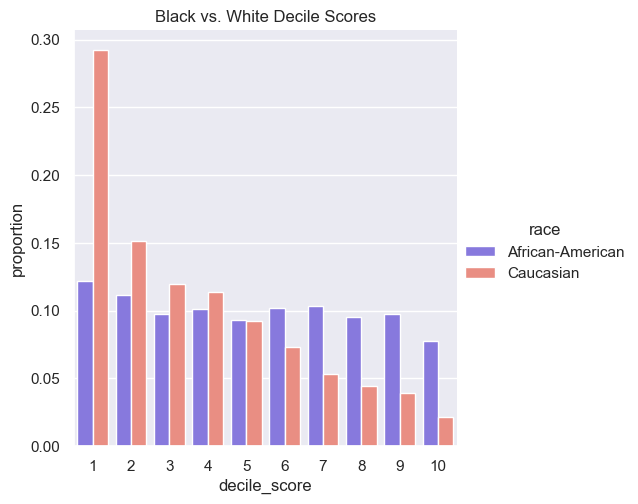

In [14]:
sns.catplot(data=bw_data, kind='bar', x='decile_score', y='proportion', hue='race', palette=['mediumslateblue', 'salmon'])
plt.title('Black vs. White Decile Scores')
plt.show()

The plot above shows the difference in distribution of decile scores between the white and black racial groups. For the white group, proportion of the group with a decile score decreases as the score increases, with the majority of the group having decile scores 1-3. For the black group, that difference is a lot less noticable. It appears that as decile score increases the proportion of the black racial group stays around the same. That is to say that the black group is roughly evenly distributed between decile scores while the white group's distribution appears more right skewed.

Below, we can see the in-data statistical parity difference between 'Caucasian' and 'African-American' race groups is -0.118. This means the privileged group, 'Caucasian', is favored over the unprivileged group, 'African-American'.

In [15]:
calculate_statistical_parity_difference(data, 'is_recid', 'race', 'Caucasian', 'African-American', 0)

-0.11801125163501047

## Model Creation

In [16]:
# One Hot Encode categorical columns
columns_to_encode = ['sex', 'age_cat', 'race', 'c_charge_degree']

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='if_binary')
encoded_columns = pd.DataFrame(encoder.fit_transform(data[columns_to_encode]))
encoded_columns.columns = encoder.get_feature_names_out(columns_to_encode)

data.reset_index(drop=True, inplace=True)
data_encoded = pd.concat([data.drop(columns_to_encode, axis=1), encoded_columns], axis=1)

In [17]:
# split data into training and test sets
X = data_encoded.drop(columns=['decile_score', 'score_text', 'is_recid'])
y = data_encoded['is_recid']

In [18]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)
print('Training data size:', X_train.shape[0])
print('Testing data size:', X_test.shape[0])

Training data size: 8008
Testing data size: 2002


### Naive Model

To create a baseline to evaluate future models, an unmodified Random Forest Classifier is used.

In [19]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
test_acc = (y_pred == y_test).mean()
print('Testing accuracy:', test_acc)

Testing accuracy: 0.7037962037962038


In [20]:
test = X_test.copy()
test['pred'] = y_pred
test = test[['id', 'pred']]
test = test.set_index('id').join(data.set_index('id'), how='inner')[['sex', 'age', 'age_cat', 'race', 'is_recid',
                                                                     'pred']]
print('Prediction Accuracy by Race:')
test.groupby('race').apply(lambda x: (x['is_recid'] == x['pred']).mean())

Prediction Accuracy by Race:


race
African-American    0.669990
Asian               0.923077
Caucasian           0.717765
Hispanic            0.754286
Native American     1.000000
Other               0.809091
dtype: float64

Statistical Parity Difference of Default Model:

In [21]:
# get dataframe
test_spd = X_test.copy()
test_spd['pred'] = y_pred
test_spd['is_recid'] = y_test
test_spd = test_spd[['id', 'race_African-American', 'is_recid', 'pred']]
# statistical parity difference
calculate_statistical_parity_difference(test_spd, 'pred', 'race_African-American', 0, 1, 0)

-0.20387985193568436

## Bias Aware Gridsearch
Now, it is time to implement BiasAwareGridSearchCV using a random forest classifier. We selected an extensive parameter grid below:

`{'n_estimators': [50, 100, 200, 500],
 'max_depth': [20, 40, 50, 100],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [2, 5, 10],
 'bootstrap': [True, False],
 'criterion': ['gini', 'entropy'],
 'max_leaf_nodes': [20, 30, 40, 50, 100],
 'class_weight': ['balanced', 'balanced_subsample']}`

In [22]:
# load in params.yaml
parent_dir = os.path.dirname(os.getcwd())
params_path = os.path.join(parent_dir, 'params.yaml')
with open(params_path, 'r') as file:
    param_grid_file = yaml.safe_load(file)

In [23]:
param_grid = param_grid_file['detailed_rfc_params']
df = X_train.join(y_train)

### Modeling

In [24]:
model = RandomForestClassifier(random_state=42)
gridsearch = BiasAwareGridSearchCV(model, param_grid, df, 'is_recid', 'race_African-American', 0, 1, 0, n_jobs= -1, verbose=False)

In [25]:
#gridsearch.fit(X_train, y_train, calculate_statistical_parity_difference)
#joblib.dump(gridsearch, 'grid_search_results.pkl')
gridsearch = joblib.load('grid_search_results.pkl')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.



['grid_search_results.pkl']

### Model Evaluation

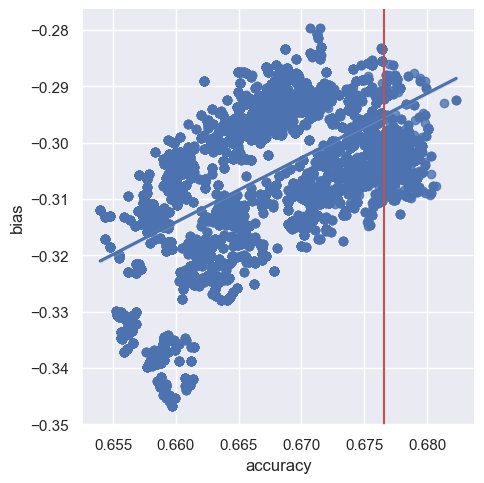

In [26]:
gridsearch.plot_accuracy(1000)

#### Accurate Model

The most accurate model 

In [27]:
acc_rf = gridsearch.select_highest_accuracy_model()
acc_rf

RandomForestClassifier(class_weight='balanced_subsample', max_depth=40,
                       max_leaf_nodes=100, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=50, random_state=42)

In [28]:
pred_train = acc_rf.predict(X_train)
result_train = X_train.copy()
result_train['pred'] = pred_train

In [29]:
(pred_train == y_train).mean(), calculate_statistical_parity_difference(result_train, 'pred', 'race_African-American', 0, 1, 0)

(0.7278971028971029, -0.28343915806347514)

In [30]:
pred_test = acc_rf.predict(X_test)
result_test = X_test.copy()
result_test['pred'] = pred_test

In [31]:
(pred_test == y_test).mean(), calculate_statistical_parity_difference(result_test, 'pred', 'race_African-American', 0, 1, 0)

(0.6763236763236763, -0.31802889629410064)

#### Least Bias Model

In [32]:
lb_rf = gridsearch.select_least_biased_model()
lb_rf

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=20,
                       max_leaf_nodes=100, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=50, random_state=42)

In [33]:
pred_train = lb_rf.predict(X_train)
result_train = X_train.copy()
result_train['pred'] = pred_train

In [34]:
(pred_train == y_train).mean(), calculate_statistical_parity_difference(result_train, 'pred', 'race_African-American', 0, 1, 0)

(0.7276473526473527, -0.27722623235576077)

In [35]:
pred_test = lb_rf.predict(X_test)
result_test = X_test.copy()
result_test['pred'] = pred_test

In [36]:
(pred_test == y_test).mean(), calculate_statistical_parity_difference(result_test, 'pred', 'race_African-American', 0, 1, 0)

(0.6728271728271729, -0.3050078992252471)

#### Balanced Model

In [37]:
bal_rf = gridsearch.select_balanced_model(5)
bal_rf

RandomForestClassifier(class_weight='balanced_subsample', max_depth=40,
                       max_leaf_nodes=100, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=50, random_state=42)

In [38]:
pred_train = bal_rf.predict(X_train)
result_train = X_train.copy()
result_train['pred'] = pred_train

In [39]:
(pred_train == y_train).mean(), calculate_statistical_parity_difference(result_train, 'pred', 'race_African-American', 0, 1, 0)

(0.7278971028971029, -0.28343915806347514)

In [40]:
pred_test = bal_rf.predict(X_test)
result_test = X_test.copy()
result_test['pred'] = pred_test

In [41]:
(pred_test == y_test).mean(), calculate_statistical_parity_difference(result_test, 'pred', 'race_African-American', 0, 1, 0)

(0.6763236763236763, -0.31802889629410064)

#### Optimum Model

In [42]:
opt_rf = gridsearch.find_optimum_model(50)
opt_rf

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=20,
                       max_leaf_nodes=100, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=50, random_state=42)

In [43]:
pred_train = opt_rf.predict(X_train)
result_train = X_train.copy()
result_train['pred'] = pred_train

In [44]:
(pred_train == y_train).mean(), calculate_statistical_parity_difference(result_train, 'pred', 'race_African-American', 0, 1, 0)

(0.7276473526473527, -0.27722623235576077)

In [45]:
pred_test = opt_rf.predict(X_test)
result_test = X_test.copy()
result_test['pred'] = pred_test

In [46]:
(pred_test == y_test).mean(), calculate_statistical_parity_difference(result_test, 'pred', 'race_African-American', 0, 1, 0)

(0.6728271728271729, -0.3050078992252471)

### Parameter Plots

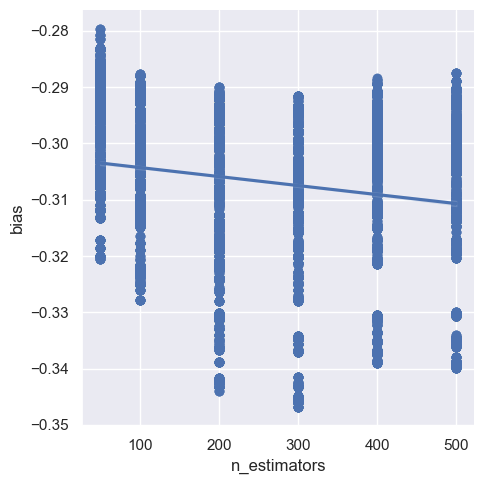

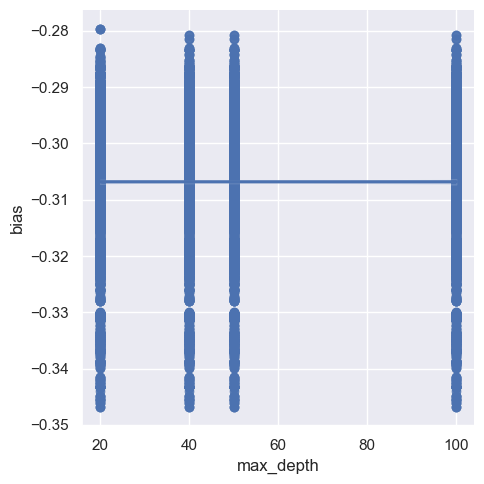

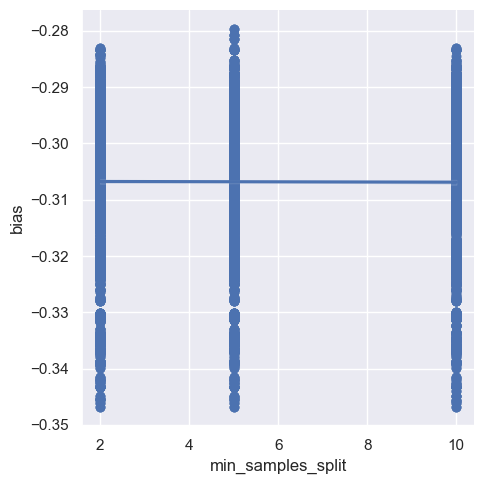

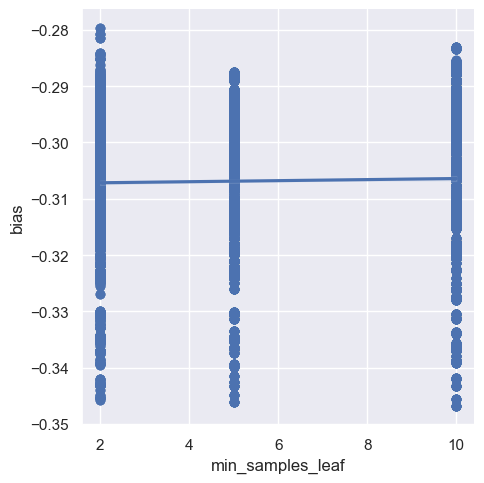

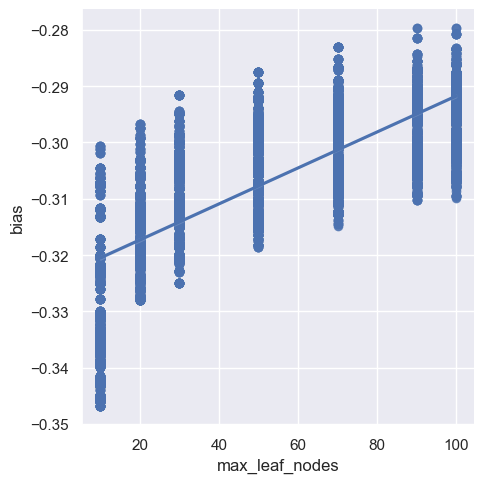

In [47]:
params = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_leaf_nodes']
for param in params:
    gridsearch.plot_params(param)

## Conclusion

BiasAwareGridSearchCV was able to decrease model bias, while keeping model accuracy.

Additionally, we can see how changing hyperparameters affected bias, specifically for n_estimators, max_leaf_nodes, and min_samples_leaf. Increasing n_estimators seems to decrease variability while minutely decreasing bias. Increasing max_leaf_nodes seems to decrease bias in a much stronger fashion, but with diminishing effects. It looks like there will be an exact value that has the least amount of bias. Increasing min_samples_leaf seems to have a similar effect as n_estimators in the way of slightly decreasing bias.